<a href="https://colab.research.google.com/github/Veronika2311/NNmethods_21/blob/main/hw2/cnn_6_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [6]:
!pip install torchmetrics

  Using cached torchmetrics-0.6.1-py3-none-any.whl (332 kB)


In [4]:
!pip install ipdb

In [7]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
from tqdm import tqdm

### Слова



### Скачивание и подготовка данных

Давайте не будем заново, мы их уже предобработали и в файл сохранили

In [8]:
train_data =  pd.read_csv('train.csv', encoding='utf8')
val_data = pd.read_csv('val.csv')

In [9]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5079447203826343

In [10]:
train_data.head(50)

,Unnamed: 0,text,type,clean_texts
0,0,"эх, ехать на репу пора((\nЗавтра уже выступление.",0,"эх , ехать на репа пора ( ( завтра уже выступл..."
1,1,"Аллергия вышла,из-за этих тупых мандарин(((((((",0,"аллергия выйти , из - за этот тупой мандарин (..."
2,2,@KompaundTone550 @tatysho власть всегда была б...,1,"власть всегда была , просто теперь об знать ве..."
3,3,"@Alinockaa А хрен, я гулящая пока, потом насиж...",1,"а хрен , я пока , потом дома : dd но сегодня я..."
4,4,"RT @vik_vans: блин, слушала первый мини-альбом...",0,"rt @vik_vans : блин , слушать первый мини - ал..."
5,5,Как же не сделать фото на айфон в зеркале:-D h...,1,как же не сделать фото на айфон в
6,6,Заебись погулял... Мама пуховик постирала ;((,0,заебись погулял ... мама пуховик постирать ; ( (
7,7,#HappyBirthdayLouisfromCIS Почему я мало пиш...,0,# почему я мало писать в тви ; ( ( ( (
8,8,@cobyisnotalone ладно :(\nмне через полтора ча...,0,ладно :( мне через полтора час только
9,9,"@DashaSone вот да, это было бы идеально! Хочу ...",1,"вот да , это было бы идеальный ! хотеть все пр..."


Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [11]:
vocab = Counter()
for text in tqdm(train_data['clean_texts']):
    vocab.update(str(text).split(' '))
print('всего уникальных слов:', len(vocab))

100%|██████████| 173952/173952 [00:00<00:00, 175220.48it/s]

всего уникальных слов: 18112


In [12]:
vocab

Counter({'эх': 697,
         ',': 143900,
         'ехать': 1089,
         'на': 28911,
         'репа': 23,
         'пора': 998,
         '(': 117281,
         'завтра': 4052,
         'уже': 8353,
         'выступление': 117,
         '.': 45625,
         'аллергия': 89,
         'выйти': 903,
         'из': 5395,
         '-': 25650,
         'за': 9271,
         'этот': 7575,
         'тупой': 406,
         'мандарин': 88,
         'власть': 122,
         'всегда': 2344,
         'была': 1543,
         'просто': 5102,
         'теперь': 4287,
         'об': 644,
         'знать': 5216,
         'весь': 9016,
         'мир': 742,
         'они': 2711,
         'сами': 223,
         'себя': 3617,
         'имидж': 7,
         'сделать': 2275,
         ')': 111651,
         'а': 26921,
         'хрен': 203,
         'я': 50091,
         'пока': 1758,
         'потом': 2099,
         'дома': 1349,
         ':': 38090,
         'dd': 947,
         'но': 12118,
         'сегодня': 6666,

In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
    else:
        print(word) # мы всё в препроцессинге удалили
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 18112


In [14]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for symbol in filtered_vocab:
    word2id[symbol] = len(word2id)

In [15]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [16]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [17]:
word2id[')'] # у нас есть скобочки, и это важно

390

## Эмбеддинги

Фасттекст так фасттекст, давайте возьмём для него леммы

In [18]:
from gensim.models import FastText

In [19]:
fasttext_data = [str(i) for i in train_data['clean_texts'].tolist()]

In [20]:
model_fasttext = FastText(fasttext_data, size=64, window=5, min_count=5)

In [21]:
#model_fasttext.wv[')'] #есть скобочки в модели!

In [22]:
model_embs = np.zeros((len(word2id), 64))
dict_of_non_wodel_embs = {} # логичнее для одинаковых слов использовать одинаковые эмбеддинги
len_non_model_words  = 0
# почему не случайные? потому что сейчас менять будем
for word, i in word2id.items():
    try:
        model_embs[i] = ft.wv[word]
    except:
        len_non_model_words += 1
        if word in dict_of_non_wodel_embs.keys():
            emb = dict_of_non_wodel_embs[word]
        else:
            emb = np.random.normal(0, 0.05, 64)
            dict_of_non_wodel_embs[word] = emb
        model_embs[i] = emb
print(len_non_model_words)

18113


### Dataset & DataLoader

In [23]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = [str(i) for i in dataset['clean_texts'].values]
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [24]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [25]:
batch = next(iter(train_iterator))

In [26]:
batch[0].shape

torch.Size([64, 35])

In [27]:
#[id2word[int(i)] for i in batch[0][0]]

In [28]:
#batch[1]

In [29]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [30]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 34])

### CNN model

In [31]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[-0.5545, -0.7392,  0.3882, -0.8005],
         [-0.3565,  0.1452,  0.2030,  0.4819],
         [ 0.2498,  0.3060,  1.0312, -0.7235],
         [-1.2128,  0.3623,  0.1080, -0.8983],
         [-0.3291, -1.3741, -0.1392,  0.1648],
         [ 0.6138, -0.1465, -0.0875,  0.2497],
         [ 1.0546,  1.3852,  0.1808, -1.7465],
         [-1.0789,  1.2346,  0.9355,  0.0666]],

        [[-1.4441, -0.7917,  0.0970,  0.3882],
         [-2.2212, -0.0326, -1.0572, -0.8956],
         [ 0.1350,  0.4578,  0.3440, -1.7167],
         [-0.9506,  0.0487,  1.2992, -0.3824],
         [ 1.0201, -0.7395, -1.5087,  1.5383],
         [-0.9850,  0.2916, -0.4326,  0.4244],
         [-0.4456, -2.1105, -0.2865, -1.4285],
         [-0.4086,  0.8346, -0.0683, -2.1030]],

        [[-0.7985,  0.3579, -0.9945, -2.3860],
         [ 1.2310, -0.2027,  0.0978,  0.7778],
         [-0.6092,  1.1835,  0.7896, -0.8010],
         [-1.0998, -1.2693,  0.3946,  0.4841],
         [-1.2863, -0.3606,  0.4209,  0.4364],
         

In [32]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[-0.5545,  0.3882],
         [ 0.1452,  0.4819],
         [ 0.3060,  1.0312],
         [ 0.3623,  0.1080],
         [-0.3291,  0.1648],
         [ 0.6138,  0.2497],
         [ 1.3852,  0.1808],
         [ 1.2346,  0.9355]],

        [[-0.7917,  0.3882],
         [-0.0326, -0.8956],
         [ 0.4578,  0.3440],
         [ 0.0487,  1.2992],
         [ 1.0201,  1.5383],
         [ 0.2916,  0.4244],
         [-0.4456, -0.2865],
         [ 0.8346, -0.0683]],

        [[ 0.3579, -0.9945],
         [ 1.2310,  0.7778],
         [ 1.1835,  0.7896],
         [-1.0998,  0.4841],
         [-0.3606,  0.4364],
         [ 1.6677,  0.9237],
         [ 2.3643,  0.1337],
         [ 0.4233,  2.1872]]])

In [33]:
fm.max(2)[0]

tensor([[ 0.3882,  0.4819,  1.0312,  0.3623,  0.1648,  0.6138,  1.3852,  1.2346],
        [ 0.3882, -0.0326,  0.4578,  1.2992,  1.5383,  0.4244, -0.2865,  0.8346],
        [ 0.3579,  1.2310,  1.1835,  0.4841,  0.4364,  1.6677,  2.3643,  2.1872]])

In [34]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_embs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(model_embs), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        #self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits

In [35]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 3697,  1685, 11262,  ...,     0,     0,     0],
        [ 2872,  6334,  9481,  ...,     0,     0,     0],
        [ 7430,  3737,  3188,  ...,     0,     0,     0],
        ...,
        [ 2678, 10343, 14130,  ...,     0,     0,     0],
        [10061,  3041,  5786,  ...,     0,     0,     0],
        [13611,  5515,   270,  ...,     0,     0,     0]])


In [36]:
print(batch)

tensor([[ 3697,  1685, 11262,  ...,     0,     0,     0],
        [ 2872,  6334,  9481,  ...,     0,     0,     0],
        [ 7430,  3737,  3188,  ...,     0,     0,     0],
        ...,
        [ 2678, 10343, 14130,  ...,     0,     0,     0],
        [10061,  3041,  5786,  ...,     0,     0,     0],
        [13611,  5515,   270,  ...,     0,     0,     0]])


In [37]:
y

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]])

In [38]:
model_embs.shape

(18113, 64)

In [39]:
model = CNN(len(id2word), 64, model_embs)
output = model(batch)
print(output)

tensor([[0.4558],
        [0.5066],
        [0.4972],
        [0.4905],
        [0.4630],
        [0.4739],
        [0.4768],
        [0.4907],
        [0.4778],
        [0.4792],
        [0.4855],
        [0.4883],
        [0.4885],
        [0.4948],
        [0.4762],
        [0.4748],
        [0.4693],
        [0.4793],
        [0.4824],
        [0.4767],
        [0.4868],
        [0.5047],
        [0.4993],
        [0.4927],
        [0.4671],
        [0.4919],
        [0.4666],
        [0.4761],
        [0.4785],
        [0.4921],
        [0.4821],
        [0.4912],
        [0.4946],
        [0.4721],
        [0.4632],
        [0.5042],
        [0.4708],
        [0.4888],
        [0.4784],
        [0.4651],
        [0.4581],
        [0.5007],
        [0.4716],
        [0.4817],
        [0.4742],
        [0.4764],
        [0.4736],
        [0.4750],
        [0.4984],
        [0.4557],
        [0.4935],
        [0.4699],
        [0.4880],
        [0.4844],
        [0.4750],
        [0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


In [40]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6956, grad_fn=<BinaryCrossEntropyBackward0>)

In [41]:
f1(output, y.long())

tensor(0.1951)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [42]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [43]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [44]:
model = CNN(len(word2id), 64, model_embs)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [45]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(4):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.23399745247831974
Train loss: 0.15176916960111825
Train loss: 0.11964058508371124
Train loss: 0.10163139660509933
Train loss: 0.08982022601354701

Evaluating on train...
Val loss: 0.038050885238157195, Val f1: 0.983944833278656
Val loss: 0.03834979573215362, Val f1: 0.9823043346405029
Val loss: 0.03837947569338717, Val f1: 0.9817924499511719
Val loss: 0.038154044893244435, Val f1: 0.9817901849746704
Val loss: 0.03810761427600658, Val f1: 0.981593132019043

Evaluating on test...
Val loss: 0.03852215752143551, Val f1: 0.9884762167930603
Val loss: 0.03737749534356666, Val f1: 0.9852287173271179
Val loss: 0.03827691181443851, Val f1: 0.9835225343704224
Val loss: 0.038380470274798364, Val f1: 0.9829717874526978
Val loss: 0.038407716984807105, Val f1: 0.9826145172119141

starting Epoch 1
Training...
Train loss: 0.03882697469164356
Train loss: 0.036730128004830456
Train loss: 0.03602213931535025
Train loss: 0.03512256103130752
Train loss: 0.03442883

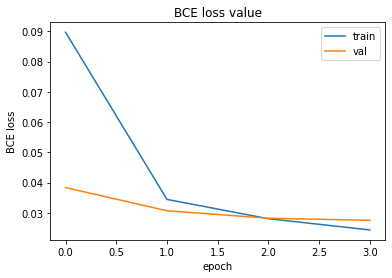

In [46]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

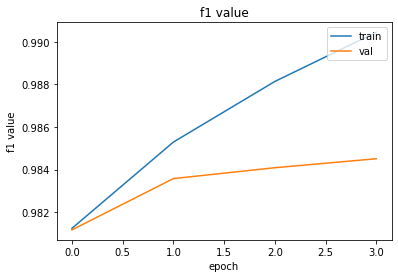

In [47]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Мы поменяли learning rate и добавили дропаут, кажется, стало лучше

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [51]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)

    return fp, fn, tp, tn

In [52]:
fp, fn, tp, tn = predict(model, val_iterator)

In [58]:
def get_metrics(fp, fn, tp, tn):
    all_preds = len(fp) + len(fn) + len(tp) + len(tn)
    print('accuracy')
    print((len(tp) + len(tn))/all_preds)
    print('precision')
    print(len(tp)/(len(fp) + len(tp)))
    print('recall')
    print(len(tp)/(len(fn) + len(tp)))

In [59]:
get_metrics(fp, fn, tp, tn)

accuracy
0.9843864974245768
precision
0.982602015454833
recall
0.9866594064797168


И что это мы тут видим? Снова смайлики! И скобочки. И ярко позитивно/негативно окрашенные слова, хотя на них одиних модель справляется куда как хуже

In [ ]:
print('Верно позитивные:', tp[:10])

In [ ]:
print('неверно негативные:', fn[:10])

In [ ]:
print('неверно позитивные:', fp[:10])

In [ ]:
print('верно негативные:', tn[:10])

In [ ]:
fp, fn, tp, tn

In [ ]:
print()